In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter

In [3]:
def load_data(image_size, labels, base_path):
    X = []
    Y = []
    for label in labels:
        folderPath = os.path.join(base_path, label)
        for img_name in os.listdir(folderPath):
            img_path = os.path.join(folderPath, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (image_size, image_size))
            X.append(img)
            Y.append(labels.index(label))
    return np.array(X), np.array(Y)

In [4]:
image_size = 150
labels = ['covid', 'pneumonia']
base_path = '/content/drive/MyDrive/covid_pneumonia/'

# Load data
X, Y = load_data(image_size, labels, base_path)

# Assume X (features) and y (labels)
X_majority = X[Y == 0]  # Majority class
X_minority = X[Y == 1]  # Minority class

# Reduce the minority class to 10% of the majority class
X_minority_downsampled, _, y_minority_downsampled, _ = train_test_split(
    X_minority, [1] * len(X_minority), test_size=0.9, random_state=42
)

# Combine with the majority class
X_imbalanced = np.vstack((X_majority, X_minority_downsampled))
Y_imbalanced = np.hstack(([0] * len(X_majority), [1] * len(X_minority_downsampled)))

print(f"Original Class Distribution: {Counter(Y)}")
print(f"Imbalanced Class Distribution: {Counter(Y_imbalanced)}")

# Step 1: Split into train + validation_temp and test
X_train, X_temp, Y_train, Y_temp = train_test_split(X_imbalanced, Y_imbalanced, test_size=0.2, random_state=42)

# Step 2: Split validation_temp into validation and test
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)


Original Class Distribution: Counter({0: 524, 1: 463})
Imbalanced Class Distribution: Counter({0: 524, 1: 46})


In [5]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen.fit(X_train)

In [7]:
def build_and_train_model(base_model, X_train, Y_train, X_val, Y_val, X_test, Y_test, labels, model_name):
    # Custom top layers
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    start_time = time.time()
    history = model.fit(train_datagen.flow(X_train, Y_train, batch_size=32),
                        epochs=10,
                        validation_data=(X_val, Y_val))
    training_time = time.time() - start_time

    plt.figure(figsize=(14, 7))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    model.save(f'lungultrasound_model_{model_name}.keras')

    test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)
    print(f"Final Test Accuracy: {test_accuracy:.4f}")
    print(f'Final Test Loss: {test_loss:.4f}')

    # Confusion Matrix and Classification Report
    Y_pred = model.predict(X_test)
    Y_pred_classes = (Y_pred > 0.5).astype(int)

    conf_matrix = confusion_matrix(Y_test, Y_pred_classes)
    class_report = classification_report(Y_test, Y_pred_classes, target_names=labels)

    print(f'Classification Report for {model_name}:')
    print(class_report)

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    return history, training_time, conf_matrix, class_report, Y_test, Y_pred_classes

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.8833 - loss: 0.8013 - val_accuracy: 0.9474 - val_loss: 0.4427
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.9861 - loss: 0.0274 - val_accuracy: 0.9474 - val_loss: 0.2143
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.9825 - val_loss: 0.1014
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.9933 - loss: 0.0288 - val_accuracy: 0.9825 - val_loss: 0.1075
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 1.0000 - loss: 8.8995e-04 - val_accuracy: 0.9825 - val_loss: 0.0608
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9825 - val_loss: 0.0492
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 1.0000 - loss: 2.2581e-04 - val_accuracy: 0.9825 - val_loss: 0.0461
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 1.0000 - loss: 5.8989e-04 - val_ac

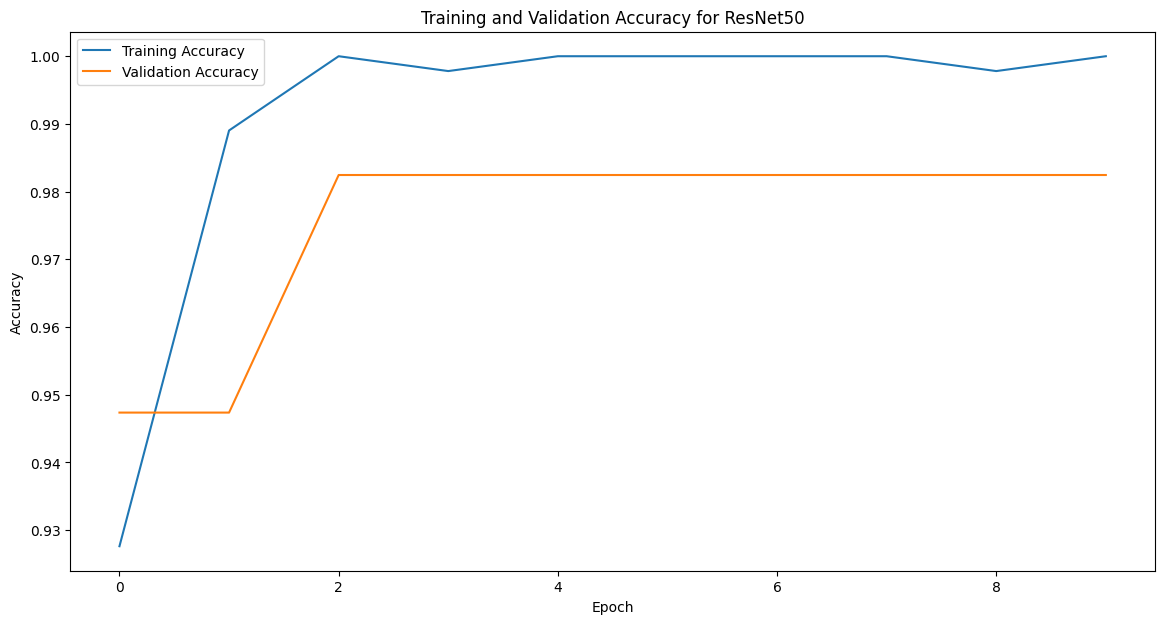

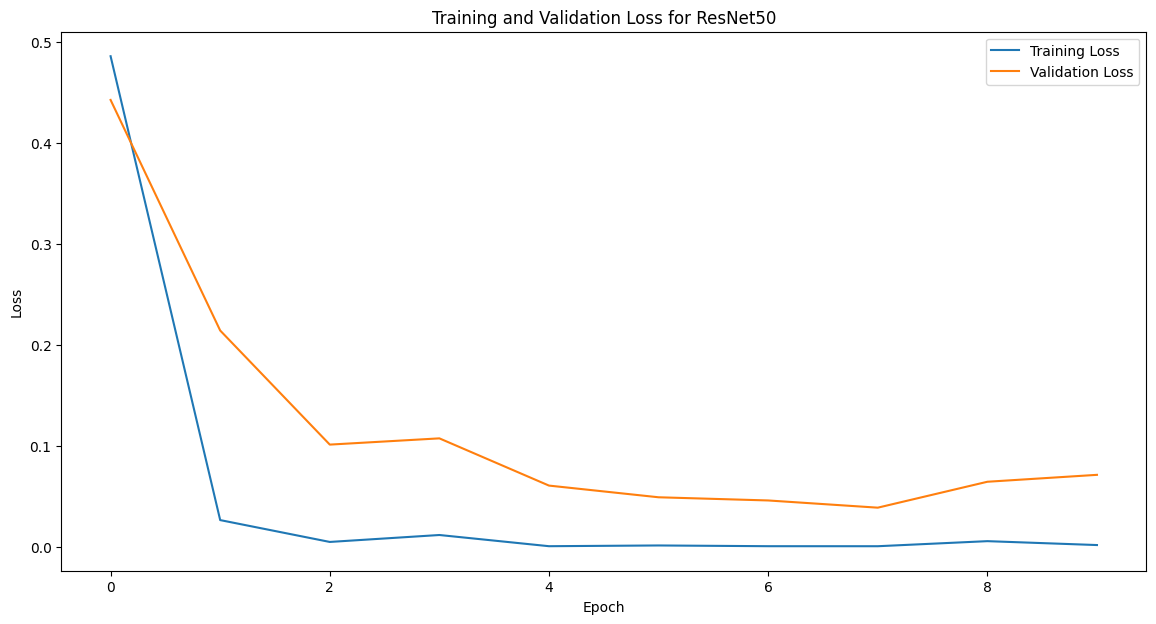

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 5.4397e-04
Final Test Accuracy: 1.0000
Final Test Loss: 0.0008
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step
Classification Report for ResNet50:
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        50
   pneumonia       1.00      1.00      1.00         7

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57



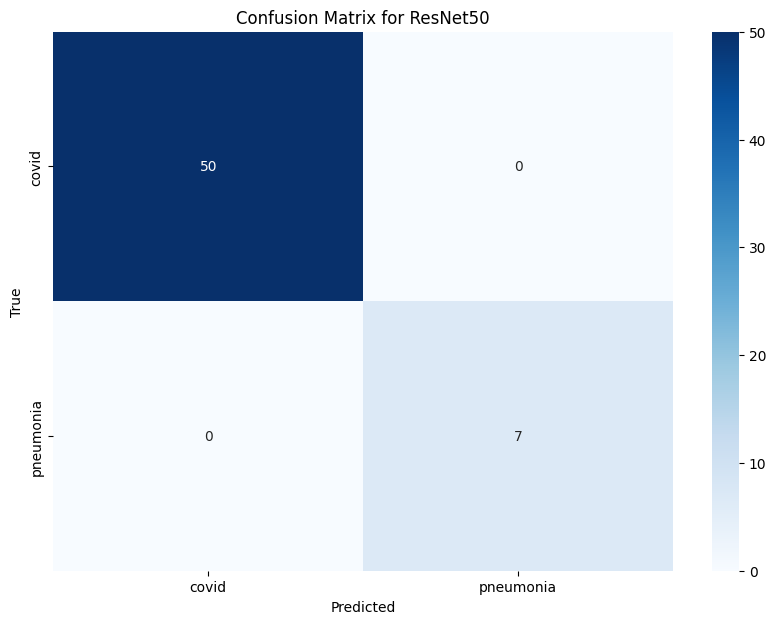

In [8]:
# Train ResNet50 Model
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
history_resnet, time_resnet, conf_matrix_resnet, report_resnet, Y_test_resnet, Y_pred_resnet = build_and_train_model(base_model_resnet, X_train, Y_train, X_val, Y_val, X_test, Y_test, labels, 'ResNet50')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8424 - loss: 1.0101 - val_accuracy: 0.9474 - val_loss: 0.1511
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step - accuracy: 0.9180 - loss: 0.2180 - val_accuracy: 0.9474 - val_loss: 0.0749
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - accuracy: 0.9481 - loss: 0.1392 - val_accuracy: 0.9474 - val_loss: 0.3110
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - accuracy: 0.9540 - loss: 0.1335 - val_accuracy: 1.0000 - val_loss: 0.0257
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - accuracy: 0.9663 - loss: 0.1024 - val_accuracy: 0.9825 - val_loss: 0.0505
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 273ms/step - accuracy: 0.9477 - loss: 0.1298 - val_accuracy: 0.9474 - val_loss: 0.0983
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step - accuracy: 0.9637 - loss: 0.0960 - val_accuracy: 0.9474 - val_loss: 0.1420
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step - accuracy: 0.9652 - loss: 0.1079 - val_accuracy: 1.00

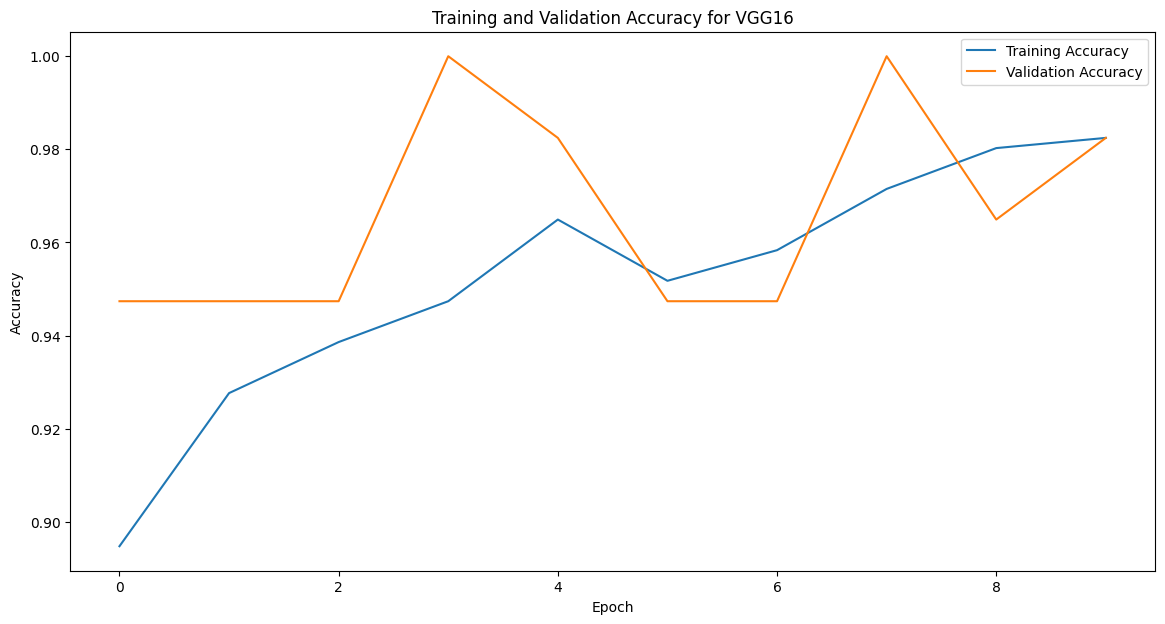

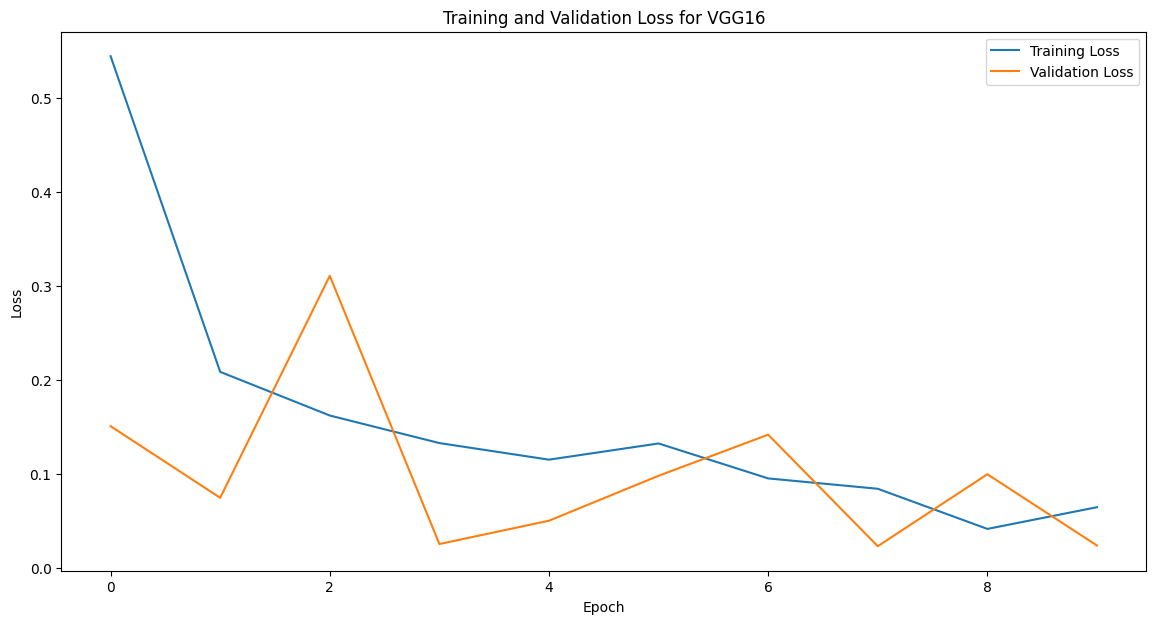

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 0.0119
Final Test Accuracy: 1.0000
Final Test Loss: 0.0120
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Classification Report for VGG16:
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        50
   pneumonia       1.00      1.00      1.00         7

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57



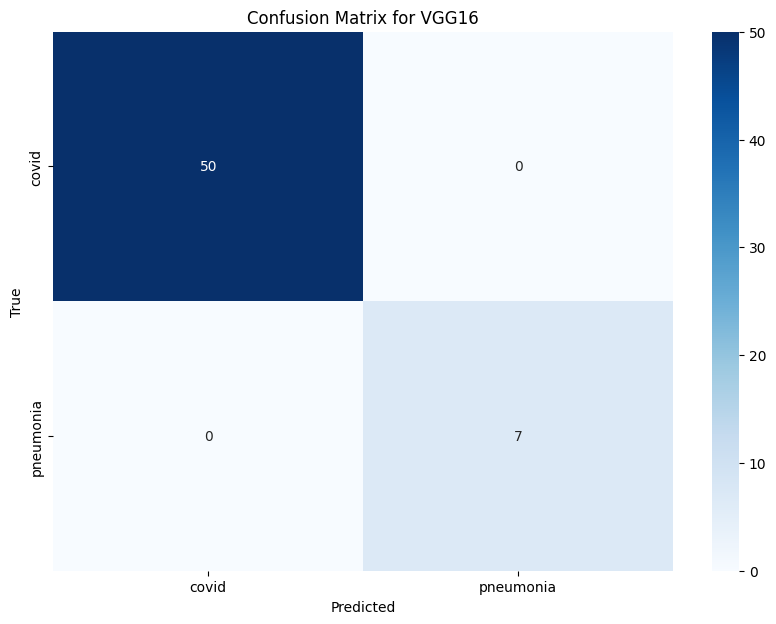

In [11]:
# Train VGG16 Model
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
history_vgg, time_vgg, conf_matrix_vgg, report_vgg, Y_test_vgg, Y_pred_vgg = build_and_train_model(base_model_vgg, X_train, Y_train, X_val, Y_val, X_test, Y_test, labels, 'VGG16')

In [12]:
def calculate_metrics(conf_matrix, Y_test, Y_pred_classes):
    # Sensitivity (Recall)
    sensitivity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

    # Specificity
    specificity = []
    for i in range(len(conf_matrix)):
        true_negatives = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
        false_positives = np.sum(np.delete(conf_matrix, i, axis=0)[:, i])
        specificity.append(true_negatives / (true_negatives + false_positives))

    # Cohen's Kappa
    kappa = cohen_kappa_score(Y_test, Y_pred_classes)

    # Classification Report (F1-score included)
    class_report_dict = classification_report(Y_test, Y_pred_classes, target_names=labels, output_dict=True)
    f1_score = {label: class_report_dict[label]['f1-score'] for label in labels}

    return sensitivity, specificity, f1_score, kappa

sensitivity_resnet, specificity_resnet, f1_score_resnet, kappa_resnet = calculate_metrics(conf_matrix_resnet, Y_test_resnet, Y_pred_resnet)
sensitivity_vgg, specificity_vgg, f1_score_vgg, kappa_vgg = calculate_metrics(conf_matrix_vgg, Y_test_vgg, Y_pred_vgg)

In [13]:
print("ResNet50 Metrics:")
print(f"Sensitivity (Recall): {sensitivity_resnet}")
print(f"Specificity: {specificity_resnet}")
print(f"F1 Score: {f1_score_resnet}")
print(f"Cohen's Kappa: {kappa_resnet}")

print("\nVGG16 Metrics:")
print(f"Sensitivity (Recall): {sensitivity_vgg}")
print(f"Specificity: {specificity_vgg}")
print(f"F1 Score: {f1_score_vgg}")
print(f"Cohen's Kappa: {kappa_vgg}")

ResNet50 Metrics:
Sensitivity (Recall): [1. 1.]
Specificity: [1.0, 1.0]
F1 Score: {'covid': 1.0, 'pneumonia': 1.0}
Cohen's Kappa: 1.0

VGG16 Metrics:
Sensitivity (Recall): [1. 1.]
Specificity: [1.0, 1.0]
F1 Score: {'covid': 1.0, 'pneumonia': 1.0}
Cohen's Kappa: 1.0
